In [16]:
import sys
sys.path.append("../src")
from bigbrotr import Bigbrotr
from event import Event
from relay import Relay
from relay_metadata import RelayMetadata
import utils
import pandas as pd

# Utils

In [ ]:
private_key, public_key = utils.generate_nostr_keypair()
e = utils.generate_event(private_key, public_key, 1, [], "test")
assert utils.verify_sig(e['id'], e['pubkey'], e['sig']), "Signature verification failed"
assert utils.calc_event_id(e['pubkey'], e['created_at'], e['kind'], e['tags'], e['content']) == e['id'], "Event ID calculation failed"
e = Event(e['id'], e['pubkey'], e['created_at'], e['kind'], e['tags'], e['content'], e['sig'])
e

# Database

In [29]:
bigbrotr = Bigbrotr(
    host="localhost",
    port=5432,
    user="admin",
    password="admin",  
    dbname="bigbrotr"
)

In [30]:
bigbrotr.connect()

In [31]:
query = """
SELECT DISTINCT relay_url
FROM events_relays
WHERE seen_at >= %s
"""
import time
now = int(time.time()) - 120
df = pd.read_sql(query, bigbrotr.conn, params=(now,))
df

/tmp/ipykernel_2345857/1400664167.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, bigbrotr.conn, params=(now,))


,relay_url


In [32]:
import psycopg2

def bytes_to_gb(b):
    return b / (1024 ** 3)

conn = psycopg2.connect(
    dbname="bigbrotr",
    user="admin",
    password="admin",
    host="localhost",
    port=5432
)
cursor = conn.cursor()

# Recupera tutte le tabelle nel tuo schema pubblico
cursor.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public' AND table_type = 'BASE TABLE'
""")
tables = [row[0] for row in cursor.fetchall()]

print("📊 Analisi dello spazio per tabella:\n")

for table in tables:
    print(f"🧾 TABELLA: {table}")
    
    # Numero righe
    cursor.execute(f"SELECT COUNT(*) FROM {table}")
    total_rows = cursor.fetchone()[0]
    print(f"Numero righe: {total_rows}")

    if total_rows == 0:
        print(" (Tabella vuota)\n")
        continue

    # Calcola dimensione media per colonna
    cursor.execute(f"""
        SELECT string_agg(
            'AVG(pg_column_size(\"' || column_name || '\")) AS \"' || column_name || '\"',
            ', '
        )
        FROM information_schema.columns
        WHERE table_name = %s AND table_schema = 'public'
    """, (table,))
    agg_expr = cursor.fetchone()[0]

    avg_size_query = f"SELECT {agg_expr} FROM {table}"
    cursor.execute(avg_size_query)
    avg_sizes = cursor.fetchone()
    colnames = [desc.name for desc in cursor.description]

    print("{:<20} {:>12} {:>12}".format("Colonna", "Avg (bytes)", "Totale (GB)"))
    total_data_bytes = 0

    for i, col in enumerate(colnames):
        avg_bytes = float(avg_sizes[i])
        total_bytes = avg_bytes * total_rows
        total_data_bytes += total_bytes
        print("{:<20} {:>12.2f} {:>12.2f}".format(col, avg_bytes, bytes_to_gb(total_bytes)))

    print(f"Totale dati stimati: {bytes_to_gb(total_data_bytes):.2f} GB")

    # Recupera indici della tabella con dimensione
    cursor.execute(f"""
        SELECT 
            indexname, 
            pg_relation_size(indexrelid) AS size_bytes
        FROM pg_indexes
        JOIN pg_class ON pg_class.relname = indexname
        JOIN pg_index ON pg_class.oid = pg_index.indexrelid
        WHERE tablename = %s
    """, (table,))
    index_data = cursor.fetchall()

    total_index_bytes = 0
    print("\n📦 Indici:")
    print("{:<30} {:>12}".format("Indice", "Size (GB)"))
    for index_name, size_bytes in index_data:
        total_index_bytes += size_bytes
        print("{:<30} {:>12.2f}".format(index_name, bytes_to_gb(size_bytes)))

    print(f"Totale indici: {bytes_to_gb(total_index_bytes):.2f} GB")
    print(f"Totale complessivo stimato: {bytes_to_gb(total_data_bytes + total_index_bytes):.2f} GB\n")
    print("─" * 60)

cursor.close()
conn.close()

📊 Analisi dello spazio per tabella:

🧾 TABELLA: events_relays
Numero righe: 360619774
Colonna               Avg (bytes)  Totale (GB)
event_id                    65.00        21.83
relay_url                   25.41         8.53
seen_at                      8.00         2.69
Totale dati stimati: 33.05 GB

📦 Indici:
Indice                            Size (GB)
events_relays_pkey                    40.75
idx_events_relays_event_id            11.10
idx_events_relays_relay_url            2.40
idx_events_relays_seen_at              2.41
Totale indici: 56.66 GB
Totale complessivo stimato: 89.71 GB

────────────────────────────────────────────────────────────
🧾 TABELLA: events
Numero righe: 100214019
Colonna               Avg (bytes)  Totale (GB)
id                          65.00         6.07
pubkey                      65.00         6.07
created_at                   8.00         0.75
kind                         4.00         0.37
tags                       300.90        28.08
content           

In [33]:
query = """
SELECT 
    relay_url,
    COUNT(*) AS event_count
FROM 
    events_relays
GROUP BY 
    relay_url
ORDER BY 
    event_count ASC;
"""
df = pd.read_sql(query, bigbrotr.conn)
df

/tmp/ipykernel_2345857/4116141653.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, bigbrotr.conn)


,relay_url,event_count
0,wss://y5ot37ckvther25mz5mlbgomkr43azjfo7bzhf6x...,1
1,wss://3amnnymetkm6wgd23tjkb3pyees4kkapltmuya5t...,1
2,wss://2u667tb3jvjynlpkzp5cngutfn4hhzgljjw6xnho...,1
3,wss://wnui6twj4axagguoklcfyy33lix6sybx5s45bjcn...,1
4,wss://lnbits.moizen.xyz/nostrrelay/moizen,1
...,...,...
890,wss://test.nfrelay.app,5384311
891,wss://thecitadel.nostr1.com,5858657
892,wss://relay.cashumints.space,6362939
893,wss://theforest.nostr1.com,6384358


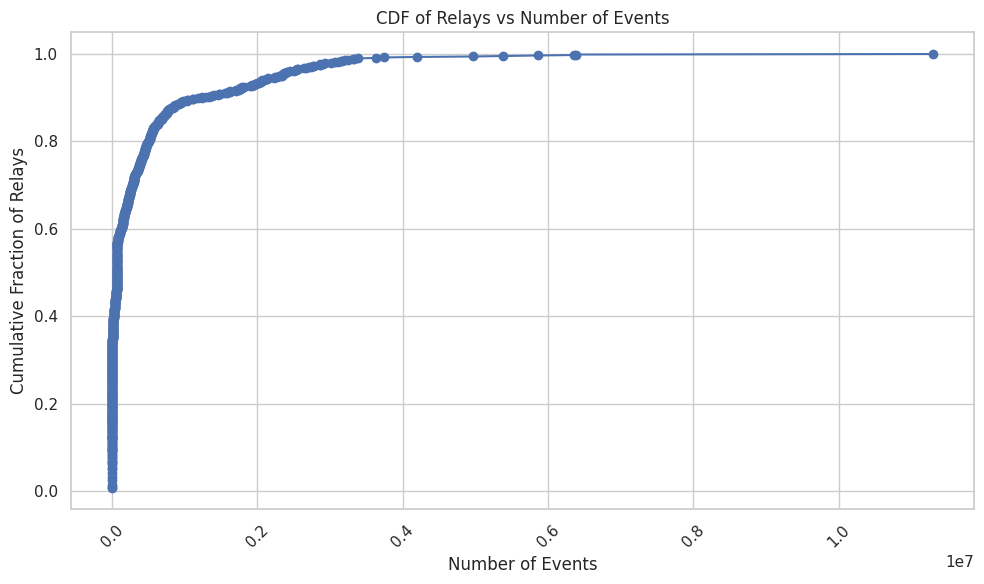

In [34]:
# plot cdf fraction of relays vs number of events
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df['event_count'].value_counts().sort_index().cumsum() / df['event_count'].count(), marker='o')
plt.title('CDF of Relays vs Number of Events')
plt.xlabel('Number of Events')
plt.ylabel('Cumulative Fraction of Relays')
plt.xticks(rotation=45)
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
query = "SELECT COUNT(*) FROM events WHERE kind = 1"
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
print(f"Number of events in the database: {rows[0][0]}")

Number of events in the database: 33131133


In [36]:
query = """
SELECT relay_url, COUNT(*) AS count
FROM relay_metadata
GROUP BY relay_url
ORDER BY count DESC
"""

bigbrotr.execute(query)
rows = bigbrotr.fetchall()

# Create DataFrame
df = pd.DataFrame(rows, columns=['relay_url', 'count'])
df

,relay_url,count
0,wss://relay.mostr.pub,33
1,wss://nostr.land,33
2,wss://henhouse.social/relay,33
3,wss://nostr.thurk.org,33
4,wss://relay.lumina.rocks,33
...,...,...
1254,wss://2bmygi42zugarkql3bx75k3l24erey3rhok4jlil...,1
1255,wss://relay2.nostr.vet,1
1256,wss://misskey.social,1
1257,wss://nostr.cercatrova.me,1


array([[<Axes: title={'center': 'count'}>]], dtype=object)

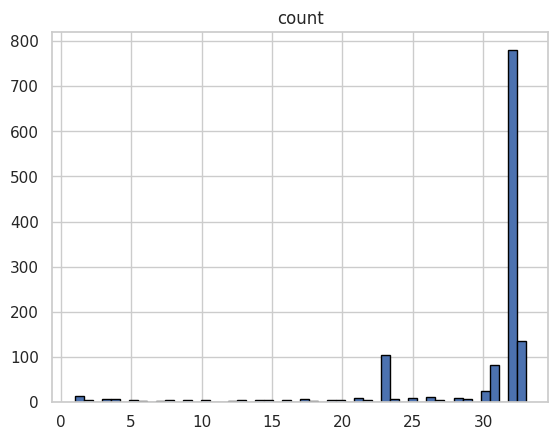

In [37]:
df.hist(column='count', bins=50, edgecolor='black')

In [ ]:
query = '''
SELECT
    er.relay_url,
    MAX(e.created_at) AS max_created_at
FROM
    events_relays er
JOIN
    events e ON e.id = er.event_id
GROUP BY
    er.relay_url
ORDER BY
    max_created_at DESC;
'''
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
df = pd.DataFrame(rows, columns=['relay_url', 'max_created_at'])

In [ ]:
df

In [ ]:
df['year_month'] = pd.to_datetime(df['max_created_at'], unit='s').dt.to_period('M')

In [ ]:
df.value_counts('year_month').sort_index().plot(kind='bar', figsize=(12, 6)) 

In [ ]:
query = """
SELECT COUNT(*)
FROM events e
WHERE NOT EXISTS (
    SELECT 1
    FROM events_relays er
    WHERE er.event_id = e.id
);
"""
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
print(f"Number of events without relays: {rows[0][0]}")

In [9]:
query = '''
SELECT COUNT(*)
FROM events_relays
WHERE relay_url = %s
'''
args = ('wss://relay.nostr.band',)
bigbrotr.execute(query, args)
rows = bigbrotr.fetchall()
rows

[(0,)]

In [ ]:
# bigbrotr.conn.autocommit = True
# bigbrotr.execute('VACUUM FULL events;')
# bigbrotr.execute('VACUUM FULL events_relays;')
# bigbrotr.execute('VACUUM FULL relay_metadata;')
# bigbrotr.execute('VACUUM FULL relays;')

In [39]:
bigbrotr.close()